# The Monsi model: Effects of carbon allocation, respiration, and assimilation on whole-plant growth

<div class="alert alert-warning">
If figures/tables are not rendered correctly, make sure your notebook is `trusted` by choosing `Trust Notebook` command found in `View` - `Activate Command Palette` menu. Typing in the first letters (i.e. "tr") should give you the command.
</div>

<div class="alert alert-info">
To run the entire code at once, go to 'Run' menu and select 'Run All Cells'. This should run all cells in sequential order. Once a cell is run, you will see a number indicating the order a cell has run in brackets like [1]. If you see [*] next to a cell, that means the cell is still running. Once all cells are run, you can manipulate the sliders to simulate changes in environmental and plant factors that you are intereste in testing and observe how the model is responding the changes you make. 
</div>

In [1]:
using Cropbox

In [2]:
Cropbox.Interact.WebIO.setup(:ijulia)

WebIO._IJuliaInit()

### Carbon partitioning

Allocation or partitioning of the photosynthates is a critical element to determine their destination and fate as to how and in what part they will be used. For example, some assimilates will be transported to roots to function as subsrates for providing ATPs to maintain the ion gradients while others can be invested back to build more new leaves. More investment in photosynthetic machinery (i.e. allocation to foliage) will yield greater return of biomass at a faster rate; this is similar to the growth of bank account balance with the compound interest rate. 

Monsi (1960)'s model as summarized in Kim et al. (2020) effectively demonstrates the importance of photosynthate allocation in plant growth.

$$
r = k (m A - n R)
$$
  
This model is simple but elegant and is robustly grounded in the ecophysiology to provide critical insights for understanding the intricate relationships between the processes of photosynthesis, respiration, and carbon allocation, and their trade-offs determining the growth of plants. The trade-offs of allocating photosynthates between photosynthetic and non-photosynthetic parts can be particularly insightful and relevant for the growth of crops like lettuce and cabbage for which the foliage biomass accounts for the majority of harvested yield or crops with large underground storage organs like radish, potato, garlic, onions, and taro. Carbon allocation to non-photosynthetic parts is also functionally important in  herbaceous perennials with storage organs such as rhizomes and woody plants for which dead parts (i.e. wood and bark) continue to be part of the whole-plant biomass.

- Table 4.1.

| Symbol | Value | Units | Description |
| :- | :- | :- | :- |
| $t$ | - | $\mathrm{d}$ | Time unit used in the model |
| $k$ | 0.0395 | - | Conversion factor from $\mathrm{CO_2}$ to biomass assuming 45% carbon in biomass |
| $m$ | 0.5 | - | Fraction of photosynthetic biomass |
| $n$ | 0.5 | - | Fraction of non-photosynthetic biomass ($1 - m$) |
| $A_{\mathrm{max}}$ | 10.0 | $$\mathrm{\mu mol}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$$ | Maximal net $\mathrm{CO_2}$ assimilation rate |
| $R_{\mathrm{max}}$ | 2.0 | $\mathrm{\mu mol}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Maximal respiration rate |
| $\alpha$ | 0.03 | $\mathrm{d^{-1}}$ | Decay rate of the growth efficiency over time |
| $A$ | - | $$\mathrm{\mu mol}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$$ | Actual net $\mathrm{CO_2}$ assimilation rate per day during photoperiod |
| $R$ | - | $$\mathrm{\mu mol}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$$ | Actual respiration rate per day |
| $D_L$ | 16 | $\mathrm{hr}$ | Day length (i.e. photoperiod) |
| $D$ | 24 | $\mathrm{hr}$ | Total hours per day |
| $r$ | - | $\mathrm{g}$ $\mathrm{g^{-1}}$ $\mathrm{d^{-1}}$ | Relative growth rate |
| $W_0$ | 1.0 | $\mathrm{g}$ | Seed mass or initial biomass |
| $W$ | - | $\mathrm{g}$ | Whole-plant biomass as dry matter |

#### Model A: Photosysnthesis and respiration remain at their maximal rate without a decrease in efficiency as plants age.

In [3]:
@system Monsi1960a(Controller) begin
    t(context.clock.time) ~ track(u"d")
    
    Amax: photosynthetic_capacity => 10.0  ~ preserve(parameter, u"μmol/m^2/s")
    C_content: biomass_carbon_content => 0.45 ~ preserve(parameter)
    k(C_content): conversion_factor => ((12/44)/1000000*(60*60*24))/C_content ~ preserve(parameter, u"g/g/μmol*s*m^2")    
#    k(C_content): conversion_factor => 0.0395 ~ preserve(parameter, u"g/g/μmol*s*m^2")    
    DL: day_length  => 16 ~ preserve(parameter, u"hr")
    D:  total_hours => 24 ~ preserve(parameter, u"hr")

    m:    leaf_mass_ratio   => 0.5 ~ preserve(parameter)
    n(m): non_leaf_fraction => 1-m ~ track

    A(DL, D, Amax): assimilation => Amax*(DL/D)  ~ preserve(parameter, u"μmol/m^2/s")
    R: respiration  => 2.0   ~ preserve(parameter, u"μmol/m^2/s")


    r(k, m, n, A, R, D, DL): RGR => k * (m*A - n*R) ~ track(u"g/g/d")

    W0:      initial_biomass => 1.0 ~ preserve(parameter, u"g")
    W(r, W): biomass         => r*W  ~ accumulate(init = W0, u"g")
end

Monsi1960a

In [4]:
c1 = @config (
    :Clock => (;
        step = 1u"d",
        ),
    :Monsi1960a => (;
        m = 0.5,
        Amax = 10.0,
        ),
    )

step,=,1 d
m,=,0.5
Amax,=,10.0


In [5]:
manipulate(Monsi1960a, :t, :W;
    config =  c1, stop = 30u"d",
    parameters = (
        :Monsi1960a =>
        (
            :m    => 0:0.05:1,        
            :DL     => 0:1:24,
            :Amax   => 0:1:50,
        ),
    ),
    xlim = (0,30),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Monsi1960a"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["m"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 21, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable{Any}(11), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007dfa1e8fab30, Task (runnable) @0x00007dfa1e8fab30), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted

In [6]:
m60a = simulate(Monsi1960a, config = c1, stop = 30u"d", snap = 30u"d")

Progress: 100%[===========================] Time: 0:00:01 (50.36 ms/it)


Row,time,t,Amax,C_content,k,DL,D,m,n,A,R,r,W0,W
,Quantity…,Quantity…,Quantity…,Float64,Quantity…,Quantity…,Quantity…,Float64,Float64,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…
1,0.0 hr,0.0 d,10.0 μmol m^-2 s^-1,0.45,0.0523636 m^2 s μmol^-1,16.0 hr,24.0 hr,0.5,0.5,6.66667 μmol m^-2 s^-1,2.0 μmol m^-2 s^-1,0.122182 d^-1,1.0 g,1.0 g
2,720.0 hr,30.0 d,10.0 μmol m^-2 s^-1,0.45,0.0523636 m^2 s μmol^-1,16.0 hr,24.0 hr,0.5,0.5,6.66667 μmol m^-2 s^-1,2.0 μmol m^-2 s^-1,0.122182 d^-1,1.0 g,31.7612 g


#### Model B: Photosysnthesis and respiration rates slow down over time. That is, the growth efficiency declines with age.

In [7]:
@system Monsi1960b(Controller) begin
    t(context.clock.time) ~ track(u"d")
    
    C_content: biomass_carbon_content => 0.45 ~ preserve(parameter)
    k(C_content): conversion_factor => ((12/44)/1000000*(60*60*24))/C_content ~ preserve(parameter, u"g/g/μmol*s*m^2")    
#    k(C_content): conversion_factor => 0.0395 ~ preserve(parameter, u"g/g/μmol*s*m^2")    
    DL: day_length  => 16 ~ preserve(parameter, u"hr")
    D:  total_hours => 24 ~ preserve(parameter, u"hr")

    m:    leaf_mass_ratio   => 0.5 ~ preserve(parameter)
    n(m): non_leaf_fraction => 1-m ~ track

    Amax: max_CO2_assimilation => 10  ~ preserve(parameter, u"μmol/m^2/s")
    Rmax: max_respiration  => 2.0   ~ preserve(parameter, u"μmol/m^2/s")
    α:    decay_rate           => 0.03  ~ preserve(parameter, u"d^-1")
    
    A(α, A): CO2_assimilation_rate => -α*A ~ accumulate(init = Amax, u"μmol/m^2/s")
    R(α, R): respiration  => -α*R ~ accumulate(init = Rmax, u"μmol/m^2/s")

    r(k, m, n, A, R, D, DL): RGR => k * (m*A*(DL/D) - n*R) ~ track(u"g/g/d")

    W0:      initial_biomass => 1.0 ~ preserve(parameter, u"g")
    W(r,α, W): biomass         => r*W  ~ accumulate(init = W0, u"g")
end

Monsi1960b

In [8]:
m60b = simulate(Monsi1960b, config = :Clock => :step => 1u"d", stop = 300u"d")

Row,time,t,C_content,k,DL,D,m,n,Amax,Rmax,α,A,R,r,W0,W
,Quantity…,Quantity…,Float64,Quantity…,Quantity…,Quantity…,Float64,Float64,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…
1,0.0 hr,0.0 d,0.45,0.0523636 m^2 s μmol^-1,16.0 hr,24.0 hr,0.5,0.5,10.0 μmol m^-2 s^-1,2.0 μmol m^-2 s^-1,0.03 d^-1,10.0 μmol m^-2 s^-1,2.0 μmol m^-2 s^-1,0.122182 d^-1,1.0 g,1.0 g
2,24.0 hr,1.0 d,0.45,0.0523636 m^2 s μmol^-1,16.0 hr,24.0 hr,0.5,0.5,10.0 μmol m^-2 s^-1,2.0 μmol m^-2 s^-1,0.03 d^-1,9.7 μmol m^-2 s^-1,1.94 μmol m^-2 s^-1,0.118516 d^-1,1.0 g,1.12218 g
3,48.0 hr,2.0 d,0.45,0.0523636 m^2 s μmol^-1,16.0 hr,24.0 hr,0.5,0.5,10.0 μmol m^-2 s^-1,2.0 μmol m^-2 s^-1,0.03 d^-1,9.409 μmol m^-2 s^-1,1.8818 μmol m^-2 s^-1,0.114961 d^-1,1.0 g,1.25518 g
4,72.0 hr,3.0 d,0.45,0.0523636 m^2 s μmol^-1,16.0 hr,24.0 hr,0.5,0.5,10.0 μmol m^-2 s^-1,2.0 μmol m^-2 s^-1,0.03 d^-1,9.12673 μmol m^-2 s^-1,1.82535 μmol m^-2 s^-1,0.111512 d^-1,1.0 g,1.39948 g
5,96.0 hr,4.0 d,0.45,0.0523636 m^2 s μmol^-1,16.0 hr,24.0 hr,0.5,0.5,10.0 μmol m^-2 s^-1,2.0 μmol m^-2 s^-1,0.03 d^-1,8.85293 μmol m^-2 s^-1,1.77059 μmol m^-2 s^-1,0.108167 d^-1,1.0 g,1.55553 g
6,120.0 hr,5.0 d,0.45,0.0523636 m^2 s μmol^-1,16.0 hr,24.0 hr,0.5,0.5,10.0 μmol m^-2 s^-1,2.0 μmol m^-2 s^-1,0.03 d^-1,8.58734 μmol m^-2 s^-1,1.71747 μmol m^-2 s^-1,0.104922 d^-1,1.0 g,1.72379 g
7,144.0 hr,6.0 d,0.45,0.0523636 m^2 s μmol^-1,16.0 hr,24.0 hr,0.5,0.5,10.0 μmol m^-2 s^-1,2.0 μmol m^-2 s^-1,0.03 d^-1,8.32972 μmol m^-2 s^-1,1.66594 μmol m^-2 s^-1,0.101774 d^-1,1.0 g,1.90465 g
8,168.0 hr,7.0 d,0.45,0.0523636 m^2 s μmol^-1,16.0 hr,24.0 hr,0.5,0.5,10.0 μmol m^-2 s^-1,2.0 μmol m^-2 s^-1,0.03 d^-1,8.07983 μmol m^-2 s^-1,1.61597 μmol m^-2 s^-1,0.0987208 d^-1,1.0 g,2.0985 g
9,192.0 hr,8.0 d,0.45,0.0523636 m^2 s μmol^-1,16.0 hr,24.0 hr,0.5,0.5,10.0 μmol m^-2 s^-1,2.0 μmol m^-2 s^-1,0.03 d^-1,7.83743 μmol m^-2 s^-1,1.56749 μmol m^-2 s^-1,0.0957592 d^-1,1.0 g,2.30566 g


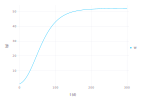

In [9]:
visualize(m60b, :t, :W, kind=:line)

In [10]:
manipulate(Monsi1960b, :t, :W;
    config =  :Clock => :step => 1u"hr", stop = 300u"d",
    parameters = 
    (
    :Monsi1960b => 
        (
        :Amax => 0:0.5:20,
        :Rmax => 0:0.1:4,
        :DL => 0:1:24,
        :m => 0:0.1:1.0,
        :α => 0:0.001:0.06,
        ),
    ),
    xlim = (0,300),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Monsi1960b"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["Amax (μmol m^-2 s^-1)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 41, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable{Any}(21), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007dfa0e283260, Task (runnable) @0x00007dfa0e283260), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json